Notebook for matching left and right frames predictions.

First we load the results and sort them by pairs

In [1]:
import json
import glob
import os 

In [2]:
results = json.load(open('/root/data/aquabyte-images/20180911_detection_small.json'))
print("Total number of images: {}".format(len(results['images'])))

Total number of images: 50


In [3]:
# timestamps dict
timestamps = {}
for path in results['images']:
    path0 = path['local_path']
    ts = int(os.path.basename(path0).split('.')[0].split('_')[-1])
    side = os.path.basename(path0).split('.')[0].split('_')[0]
    if ts not in timestamps:
        timestamps[ts] = {}
    timestamps[ts][side] = path0
    timestamps[ts][side + "_id"] = path['id']

In [4]:
print("number of pairs: {}".format(len([v for (k, v) in timestamps.items() if "right" in v and "left" in v])))

number of pairs: 23


In [5]:
pairs = [v for (k, v) in timestamps.items() if "right" in v and "left" in v]

So we have 1023 pairs.

### Visualization

In [6]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import json
import matplotlib.patches as patches

In [7]:
json_path = '/root/data/aquabyte-images/20180911_detection_small.json'
example_coco = COCO(json_path)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [8]:
category_ids = example_coco.getCatIds(catNms=['square'])
image_ids = example_coco.getImgIds(catIds=category_ids)
image_data = example_coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]

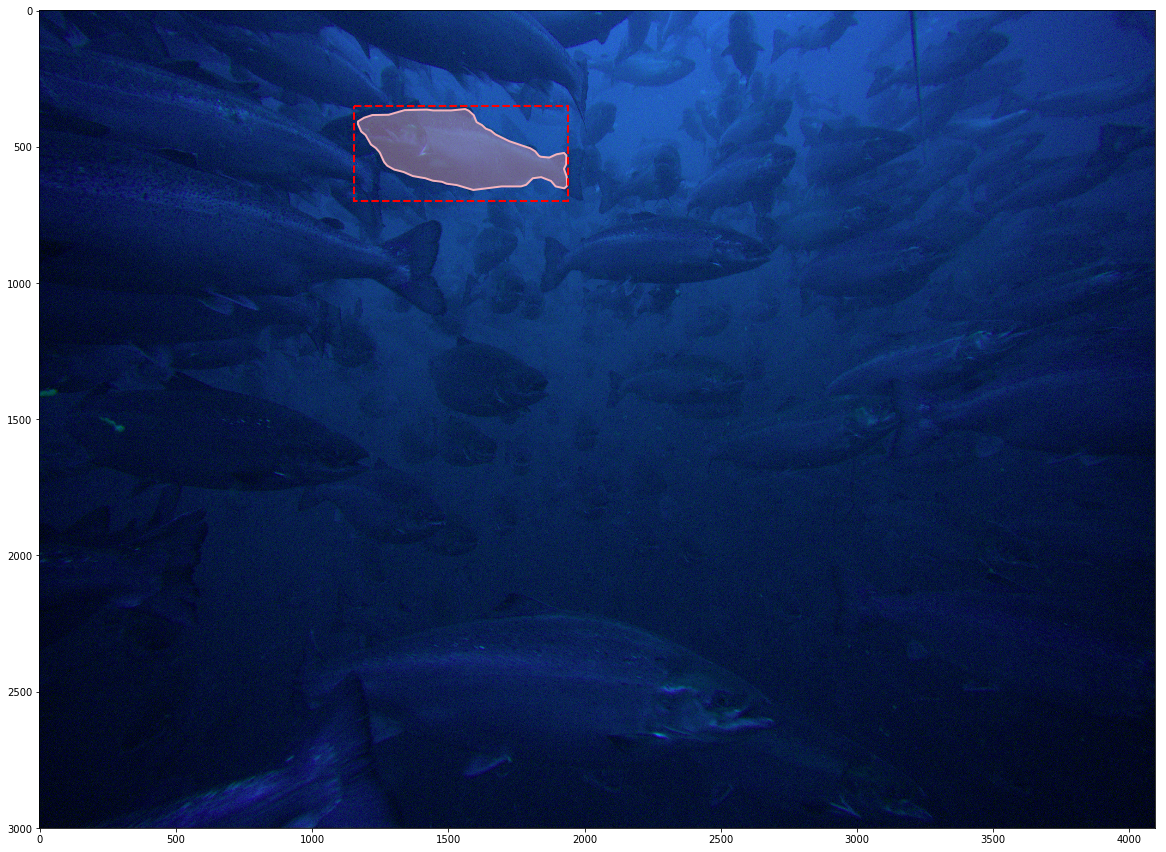

In [9]:
# load and display instance annotations
image = io.imread(image_data['local_path'])
f ,ax = plt.subplots(1, figsize=(20, 20))
ax.imshow(image); 
# ax.axis('off')
# plt.axis('off')
# pylab.rcParams['figure.figsize'] = (8.0, 10.0)
annotation_ids = example_coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = example_coco.loadAnns(annotation_ids)
example_coco.showAnns(annotations)
for ann in annotations:
    bbox = ann['bbox']
    rec = patches.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], 
                            edgecolor='r', facecolor=None, fill=False, linestyle='--', linewidth=2)
    ax.add_patch(rec)
    # ax.text(bbox[0], bbox[1]-10, id2class[str(ann['category_id'])], fontsize=16)
plt.show()

### Matching

First strategy: matching using bounding boxes only! We calculate a score for each pairs of bboxes.

In [10]:
# pair = np.random.choice(pairs)
pair = pairs[1]

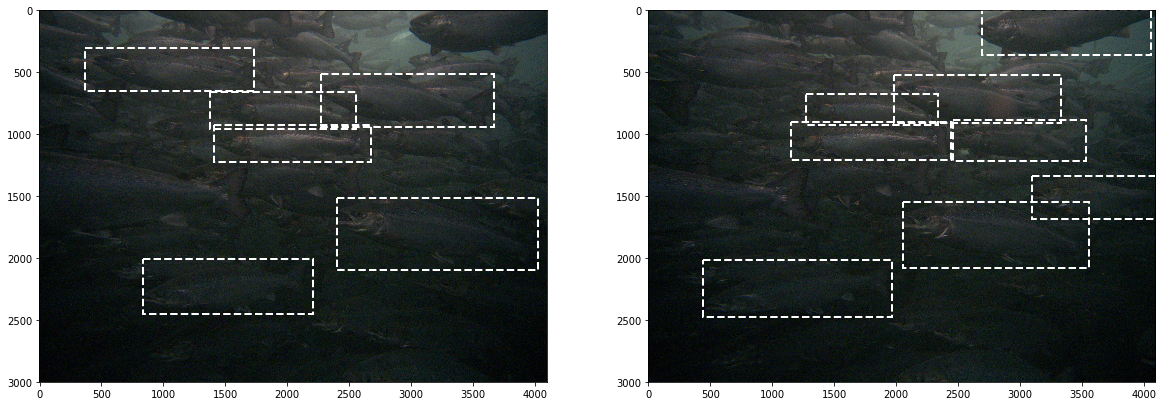

In [11]:
# let's plot a pair of images
f ,ax = plt.subplots(1, 2, figsize=(20, 20))

# plot left image and annotations
left_image_data = example_coco.loadImgs(pair['right_id'])[0]
left_image = io.imread(left_image_data['local_path'])
left_annotation_ids = example_coco.getAnnIds(imgIds=left_image_data['id'], catIds=category_ids, iscrowd=None)
left_annotations = example_coco.loadAnns(left_annotation_ids)
for ann in left_annotations:
    bbox = ann['bbox']
    rec = patches.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], 
                            edgecolor='w', facecolor=None, fill=False, linestyle='--', linewidth=2)
    ax[0].add_patch(rec)
ax[0].imshow(left_image)

# plot right image and annotations
right_image_data = example_coco.loadImgs(pair['left_id'])[0]
right_image = io.imread(right_image_data['local_path'])
right_annotation_ids = example_coco.getAnnIds(imgIds=right_image_data['id'], catIds=category_ids, iscrowd=None)
right_annotations = example_coco.loadAnns(right_annotation_ids)
for ann in right_annotations:
    bbox = ann['bbox']
    rec = patches.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], 
                            edgecolor='w', facecolor=None, fill=False, linestyle='--', linewidth=2)
    ax[1].add_patch(rec)
ax[1].imshow(right_image)
plt.show()

In [12]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import euclidean_distances

In [13]:
# let's use x1, x2 to match bboxes
left_centroids = []
for ann in left_annotations:
    bbox = ann['bbox']
    # centroid = [(bbox[3] - bbox[1])/2.0, (bbox[2] - bbox[0])/2.0]
    centroid = [bbox[2], bbox[0]]
    left_centroids.append(centroid)
    
right_centroids = []
for ann in right_annotations:
    bbox = ann['bbox']
    # centroid = [(bbox[3] - bbox[1])/2.0, (bbox[2] - bbox[0])/2.0]
    centroid = [bbox[2], bbox[0]]
    right_centroids.append(centroid)

print("Number of left centroids: {}".format(len(left_centroids)))
print("Number of right centroids: {}".format(len(right_centroids)))

Number of left centroids: 6
Number of right centroids: 8


In [14]:
centroid

[364, 0]

In [15]:
cost_matrix = euclidean_distances(left_centroids, right_centroids)

In [16]:
row_ind, col_ind = linear_sum_assignment(cost_matrix)

In [19]:
for (r, c) in zip(row_ind, col_ind):
    print(cost_matrix[r, c])
    print(left_centroids[r], right_centroids[c])

31.575306807693888
([941, 513], [910, 519])
30.364452901377952
([2450, 2005], [2479, 2014])
24.186773244895647
([1224, 926], [1212, 905])
33.61547262794322
([2093, 1516], [2080, 1547])
33.83784863137726
([959, 663], [927, 674])
422.3138643236805
([654, 307], [364, 0])


### debugging

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import json
import matplotlib.patches as patches

from PIL import Image, ImageDraw
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from utils import *

In [ ]:
f ,ax = plt.subplots(1, 2, figsize=(20, 20))
left_image = io.imread('./out2/1/input/right_frame.jpg')
left_annotations = json.load(open('./out2/1/input/right_frame.jpg.segmentation.prediction.json'))['annotations']
for ann in left_annotations:
    bbox = ann['bbox']
    rec = patches.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], 
                            edgecolor='w', facecolor=None, fill=False, linestyle='--', linewidth=2)
    ax[0].add_patch(rec)
ax[0].imshow(left_image)

# plot right image and annotations
right_image = io.imread('./out2/1/input/left_frame.jpg')
right_annotations = json.load(open('./out2/1/input/left_frame.jpg.segmentation.prediction.json'))['annotations']
for ann in right_annotations:
    bbox = ann['bbox']
    rec = patches.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], 
                            edgecolor='w', facecolor=None, fill=False, linestyle='--', linewidth=2)
    ax[1].add_patch(rec)
ax[1].imshow(right_image)
plt.show()

In [ ]:
# let's use x1, x2 to match bboxes
left_centroids = []
for ann in left_annotations:
    bbox = ann['bbox']
    # centroid = [(bbox[3] - bbox[1])/2.0, (bbox[2] - bbox[0])/2.0]
    centroid = [bbox[2], bbox[0]]
    left_centroids.append(centroid)
    
right_centroids = []
for ann in right_annotations:
    bbox = ann['bbox']
    # centroid = [(bbox[3] - bbox[1])/2.0, (bbox[2] - bbox[0])/2.0]
    centroid = [bbox[2], bbox[0]]
    right_centroids.append(centroid)

print("Number of left centroids: {}".format(len(left_centroids)))
print("Number of right centroids: {}".format(len(right_centroids)))

In [ ]:
cost_matrix = euclidean_distances(left_centroids, right_centroids)

In [ ]:
row_ind, col_ind = linear_sum_assignment(cost_matrix)

In [ ]:
matched_annotations = []
for (r, c) in zip(row_ind, col_ind):
    if cost_matrix[r, c] < 100.0:
        matched_annotations.append([left_annotations[r], right_annotations[c]])

In [ ]:
matched_annotations

In [ ]:
# then let's calculate the biomass
weights = []
for pair in matched_annotations:
    weights.append(weight_estimator(pair[0], pair[1]))

In [ ]:
weights

In [ ]:
pair[0]

In [ ]:
pair[1]